# Starbucks Segmentation: Modeling

The data used in this part of the notebook is stored in [customers.csv](data/customers.csv) file. The data cleaning and transformation details can be found in [Cleansing_and_Wrangling](Cleansing_and_Wrangling.ipynb) notebook. In this part of the notebook, I will be reducing the dimensions of the data using Principle Component Analysis (PCA), then scaling the values using the Standard Scaler function from the Scikit-learn library and finally using K-Means from the Scikit-learn library to form the clusters.

In [16]:
"Import the required librarries"
#scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#principle component analysis
from sklearn.decomposition import PCA
import time
#validation
from sklearn import metrics
#clustering
from sklearn.cluster import KMeans
#data manipulation library
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
#cluster visualization
from yellowbrick.cluster.elbow import kelbow_visualizer

#set graphic properties
%matplotlib inline
%config InlineBackend.figure_format='retina'

#manage warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
#load the data
customer_df = pd.read_csv('data/customers.csv', index_col=[0])
print('Shape of the customer dataframe ', str(customer_df.shape))
customer_df.head(3)

Shape of the customer dataframe  (17000, 34)


,age,income,informational_vr,informational_cr,bogo_vr,bogo_cr,discount_vr,discount_cr,bogo_received_cnt,bogo_viewed_cnt,...,avg_discount_rewards,gender_F,gender_M,gender_O,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
person,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,53.0,59000.0,0.0,0.0,0.0,0.0,1.0,0.4,0.0,0.0,...,0.416667,0,1,0,0,0,0,0,1,0
0610b486422d4921ae7d2bf64640c50b,55.0,112000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1,0,0,0,0,0,0,1,0
38fe809add3b4fcf9315a9694bb96ff5,53.0,59000.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.000000,0,1,0,0,0,0,0,0,1


## Feature Scaling

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). In standard scaler centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

In [18]:
#scale the data
std_scaler = StandardScaler().fit(customer_df)
scaled_cust = std_scaler.transform(customer_df)

## Principle Component Analysis (PCA)

Principle Component Analysis uses linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD. 

In [19]:
#reduce the dimensions using PCA
pca = PCA()
X_pca = pca.fit_transform(scaled_cust)

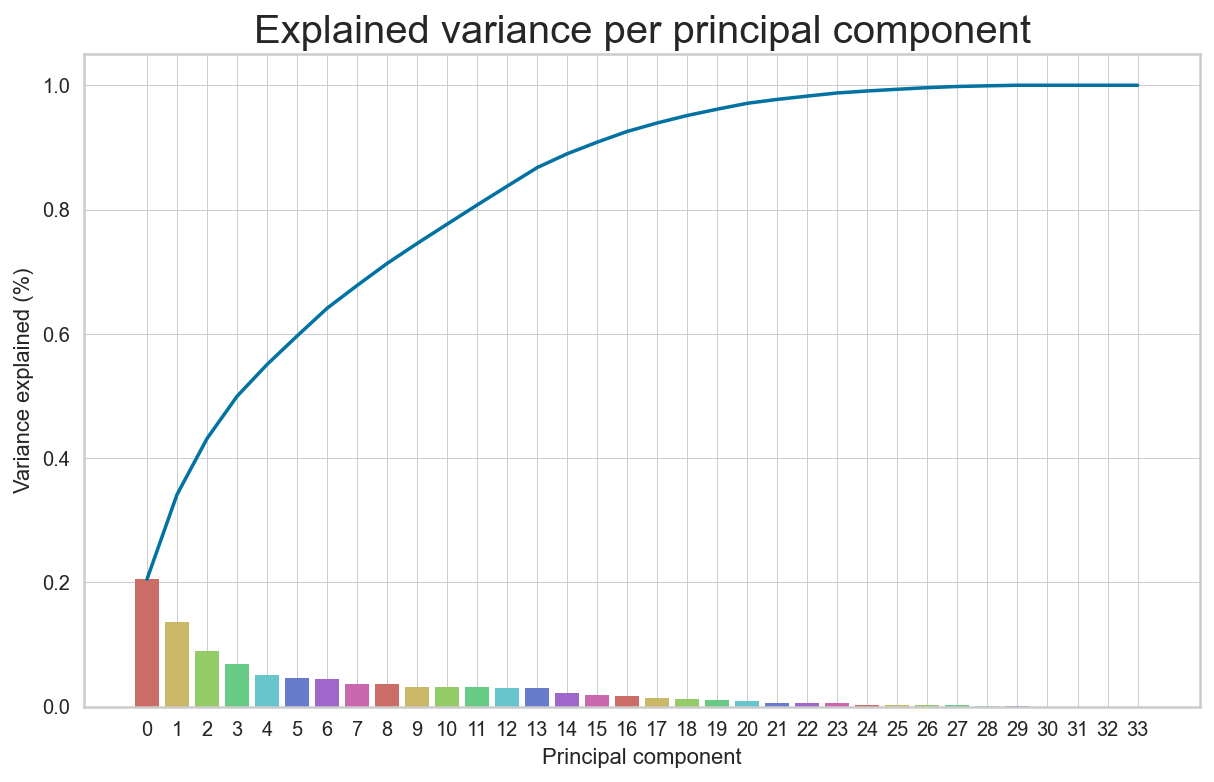

In [20]:
# Scree plot (variance explained by each principal component)
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize=(10,6))

ax = sns.barplot(ind, vals, palette= sns.color_palette("hls", 8), ci=None)
ax2 = sns.lineplot(ind, cumvals, ci=None)
ax.grid(b=True, which='major', linewidth=0.5)

ax.set_xlabel("Principal component");
ax.set_ylabel("Variance explained (%)");
plt.title('Explained variance per principal component', fontdict={"fontsize": "20"});

I will keep the features that together explain atleast 80% of the variance. Then the PCA will be applied again this time with the components number retrived from the variance explained ratio.

In [21]:
# get components that explain 80% of the variance
cs_var_explained = np.cumsum(pca.explained_variance_ratio_)
components = len(cs_var_explained[cs_var_explained <= 0.80])
print(str(components) + " components explain 80% of variance")

11 components explain 80% of variance


In [22]:
#apply pca again with 11 components
pca = PCA(components).fit(scaled_cust)
cust_pca = pca.transform(scaled_cust)
cust_pca.shape

(17000, 11)

## Clustering

In [23]:
def get_silhouette_score(clusters):
    '''
    function calculates silhouette scores for the given clusters list
    using the K-means and return a dataframe.
    
    INPUT:
        1. clusters(list): list of clusters to check the silhouette score
        
    OUTPUT:
        1. df(pandas dataframe): dataframe with cluster and its associated silhouette score
    '''
    #define a dataframe
    df = pd.DataFrame(columns=['cluster', "silhouette_Score", "distortions"])
    #loop through the clusters
    for c in clusters:
        cluster = KMeans(n_clusters=c, n_init=100, init='k-means++').fit(cust_pca)
        #compute the silhouette score
        sh_score = metrics.silhouette_score(cust_pca, cluster.labels_, metric='euclidean')
        #get the distortions
        distortions = cluster.inertia_
        #assign to the dataframe
        df.loc[len(df)] = [c, sh_score, distortions]
    
    return df

cluster_list = [2, 3, 5, 8, 10, 15]
df_kmeans = get_silhouette_score(cluster_list)
df_kmeans

,cluster,silhouette_Score,distortions
0,2.0,0.195814,349491.265794
1,3.0,0.168605,311940.102174
2,5.0,0.130051,273620.686959
3,8.0,0.121403,246330.198992
4,10.0,0.114617,233035.434907
5,15.0,0.126180,206523.550108


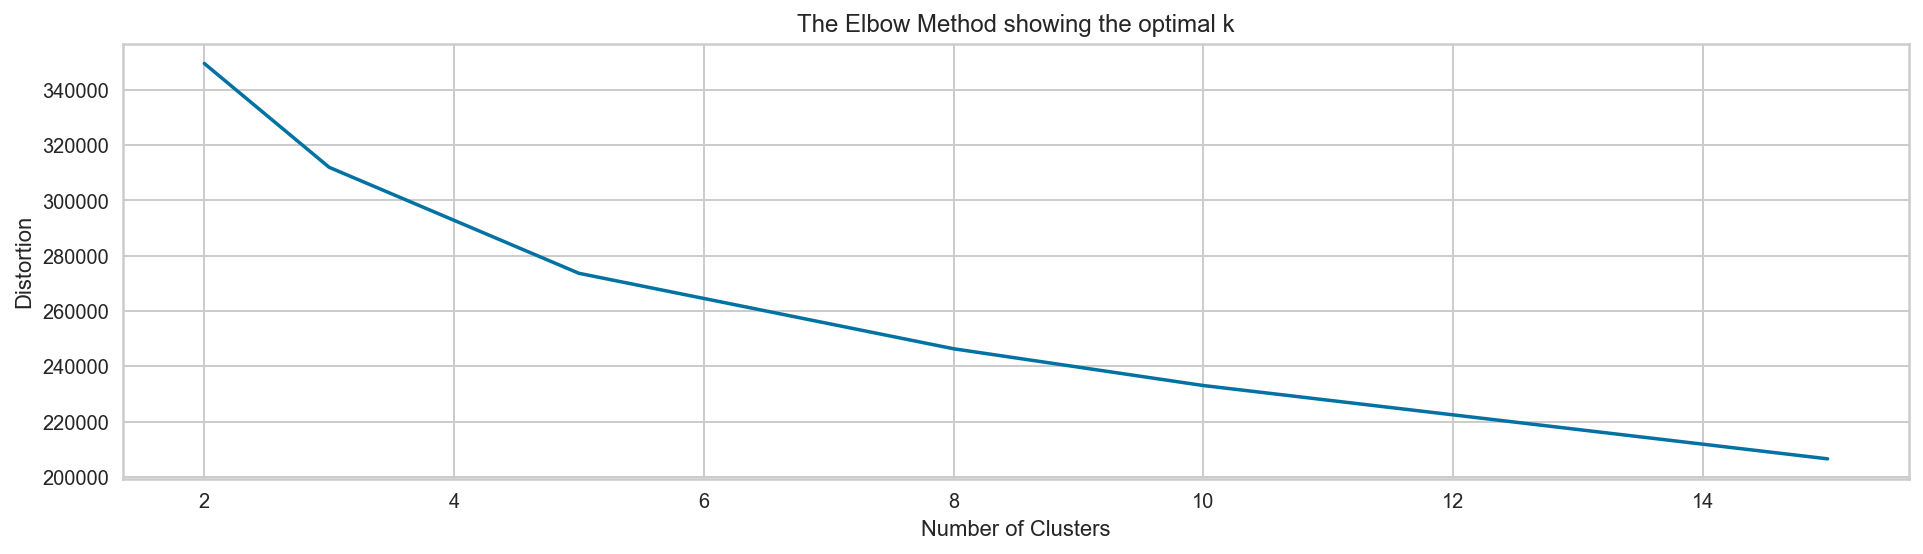

In [24]:
#plot the distortions in elbow graph
plt.figure(figsize=(16,4))
plt.plot(df_kmeans.cluster, df_kmeans.distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the eblow plot it can be observed that there are two possible clusters k = 3 & k = 5. However, the k = 3 has higher silhouette score as compared to k=5. Therefore, I will be using 3 clusters and refitting the model again with 3 clusters.

In [25]:
#refit the model
cluster = KMeans(n_clusters=3, n_init=100, init='k-means++').fit(cust_pca)
#compute the silhouette score
sh_score = metrics.silhouette_score(cust_pca, cluster.labels_, metric='euclidean')
print("Silhouette score: " + str(sh_score))

Silhouette score: 0.16859930571272552


In [26]:
#get the predictions
kmeans_predictions = cluster.predict(cust_pca)

In [27]:
df = customer_df.copy().reset_index()
df['cluster'] = kmeans_predictions
df = df.melt(id_vars=['person', 'cluster'])
df = df.query('cluster != -1').groupby(['cluster', 'variable']).mean().reset_index()
df.head()

,cluster,variable,value
0,0,age,57.406686
1,0,avg_amount,21.833238
2,0,avg_bogo_rewards,2.479183
3,0,avg_discount_rewards,0.806586
4,0,avg_rewards,2.766571


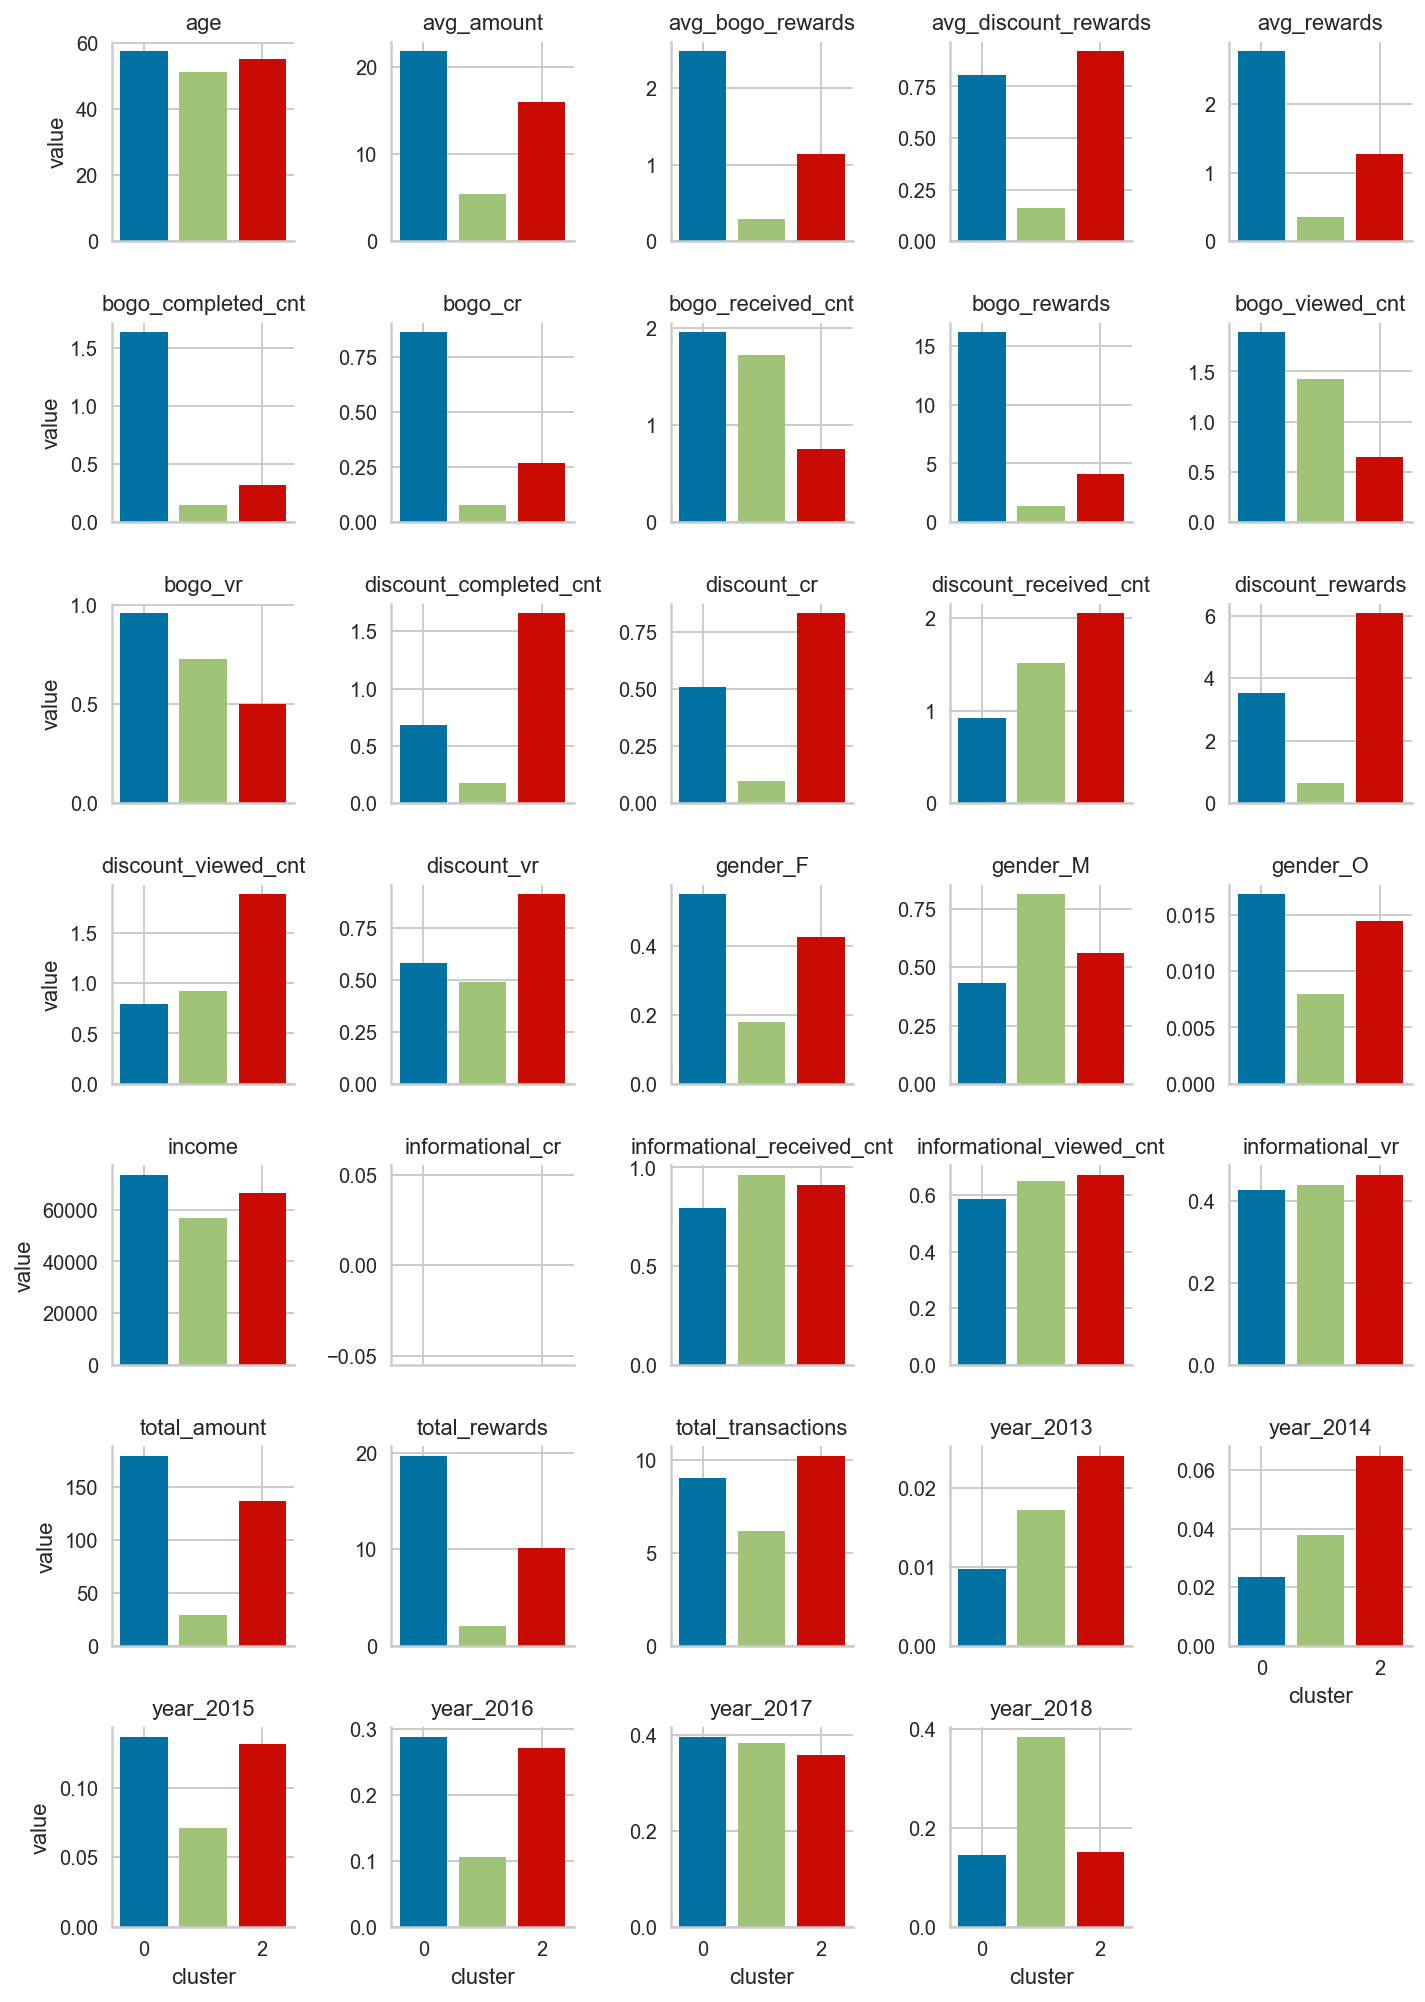

In [29]:
g = sns.FacetGrid(df, col='variable', hue='cluster', col_wrap=5, height=2, sharey=False)
g = g.map(plt.bar, 'cluster', 'value').set_titles("{col_name}");

## Cluster Analysis

### Segment 1: Bogo Group

* Majority of the customers in this group are Females followed by the Other Category.
* As the name of the group suggests, this group mainly receives/views/completes the BOGO offers. As a result, they have higher bogo rewards awarded to them.
* In addtion, this group also has the highest income of all three segments, as well as total amount spent by them in transactions is also the highest.
* Finally, majority of the customers from this group became members from the year 2015 to 2017.

### Segment 2: Passive Group

* Majority of the customers in this group are Male and recevie highest number of informational offers.
* Altough, they have a decent view rate for both BOGO & DISCOUNT offers, the hardly ever opt in and complete the transactions using these offers.
* They also have the lowest income of all three groups, and most of them became members in the past couple of years i.e 2017 & 2018.

### Segment 3: Discount Group

* Majority of the customers in this group belong to the Other Category, followed by Female customers.
* This group receives/views/completes highest number of DISCOUNT offers. As a result, they have higher discount rewards awarded to them. In addtion, this group also recevies highest number of informational offers.
* The transactions completed by this group is the highest as compared to rest of the groups.
* Finally, these people have been the customers of starbucks consistently since 2013. 

## Customers Per Cluster

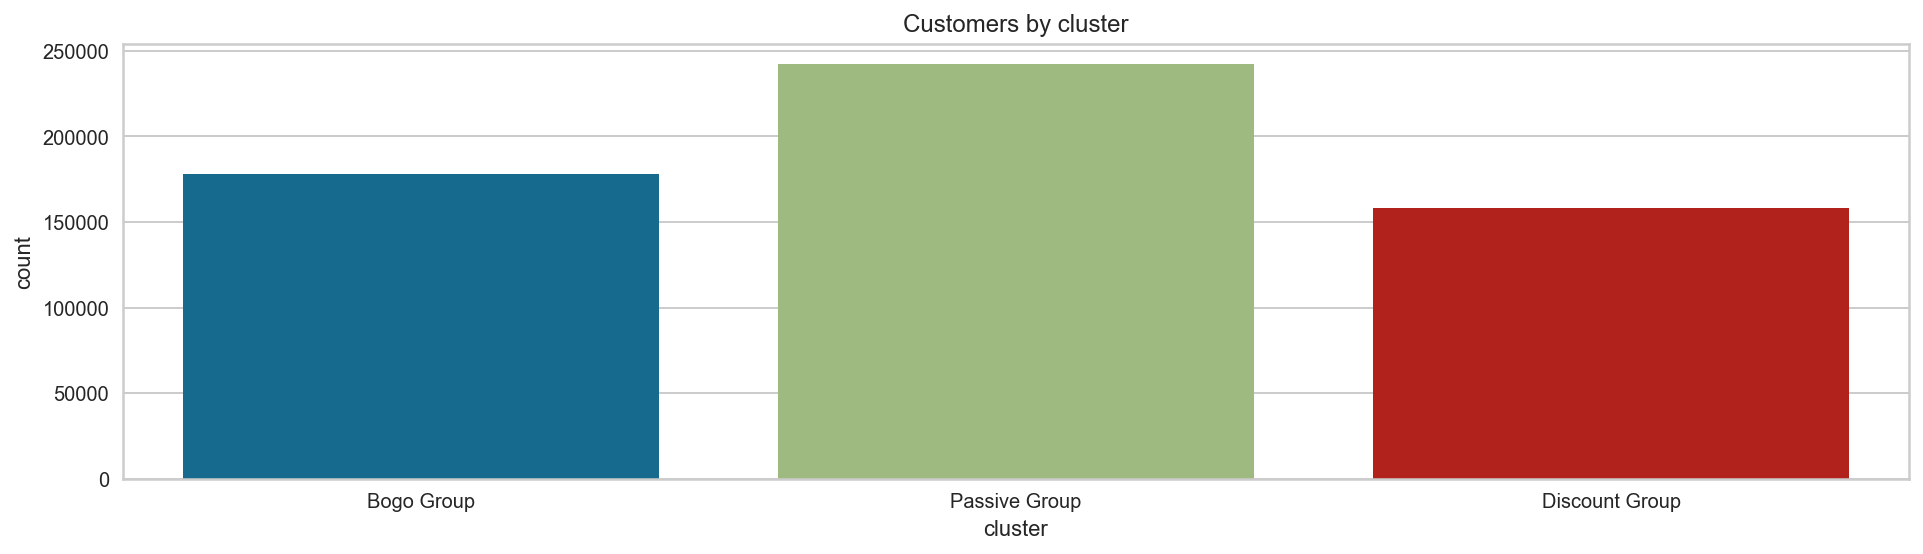

In [34]:
# plot total number of customers per cluster
df = customer_df.copy().reset_index()
df['cluster'] = kmeans_predictions
df = df.melt(id_vars=['person', 'cluster'])
df.head()
plt.figure(figsize=(16,4))
ax = sns.countplot(x='cluster', data=df)
ax.set_title('Customers by cluster');
ax.set_xticklabels(('Bogo Group', 'Passive Group', 'Discount Group'));

As the graph describes, majority of the customers are from the Passive Group, while a lot of customers seem to prefer BOGO offer as the bogo group has higher number compared to the Discount Group.